# Word2Vec (Negative Sampling)

Let's work on negative-sampling based implementation of word2vec.


In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import torch.nn.functional as F

In [2]:
# Detect the device for computation (CPU/GPU/Metal on Mac 💻)
device = torch.device(
    "mps"
    if torch.backends.mps.is_available()
    else ("cuda" if torch.cuda.is_available() else "cpu")
)
print(f"Using device: {device}")

Using device: cuda


## 1. Define some very simple data for understanding


In [3]:
import nltk
from nltk.corpus import reuters

# SAMPLE_SIZE = 100
SAMPLE_SIZE = len(reuters.fileids())
corpus = []


for id in reuters.fileids()[:SAMPLE_SIZE]:
    sentences = reuters.words(id)
    sentences = [
        sentence.lower() for sentence in sentences if sentence.isalpha()
    ]
    corpus.append(sentences)

print(corpus[:1])

[['asian', 'exporters', 'fear', 'damage', 'from', 'u', 's', 'japan', 'rift', 'mounting', 'trade', 'friction', 'between', 'the', 'u', 's', 'and', 'japan', 'has', 'raised', 'fears', 'among', 'many', 'of', 'asia', 's', 'exporting', 'nations', 'that', 'the', 'row', 'could', 'inflict', 'far', 'reaching', 'economic', 'damage', 'businessmen', 'and', 'officials', 'said', 'they', 'told', 'reuter', 'correspondents', 'in', 'asian', 'capitals', 'a', 'u', 's', 'move', 'against', 'japan', 'might', 'boost', 'protectionist', 'sentiment', 'in', 'the', 'u', 's', 'and', 'lead', 'to', 'curbs', 'on', 'american', 'imports', 'of', 'their', 'products', 'but', 'some', 'exporters', 'said', 'that', 'while', 'the', 'conflict', 'would', 'hurt', 'them', 'in', 'the', 'long', 'run', 'in', 'the', 'short', 'term', 'tokyo', 's', 'loss', 'might', 'be', 'their', 'gain', 'the', 'u', 's', 'has', 'said', 'it', 'will', 'impose', 'mln', 'dlrs', 'of', 'tariffs', 'on', 'imports', 'of', 'japanese', 'electronics', 'goods', 'on', '

In [4]:
# corpus = ["apple banana fruit", "banana apple fruit", "banana fruit apple",
#                  "dog cat animal", "cat animal dog", "cat dog animal"]

In [5]:
# corpus = [sent.split(" ") for sent in corpus]
# corpus

In [6]:
# get word sequences and unique words
flatten = lambda l: [item for sublist in l for item in sublist]
vocab = list(set(flatten(corpus)))
# vocab

In [7]:
# numericalization
word2index = {w: i for i, w in enumerate(vocab)}
# print(word2index)

In [8]:
# vocab size
voc_size = len(vocab)
# print(voc_size)

In [9]:
# append UNK
vocab.append("<UNK>")

In [10]:
# vocab

In [11]:
word2index["<UNK>"] = 0

In [12]:
# just in case we need to use
index2word = {v: k for k, v in word2index.items()}

## 2. Prepare train data


In [13]:
# for c in corpus:
#     print(c)

In [14]:
def random_batch(batch_size, word_sequence):

    # Make skip gram of one size window
    skip_grams = []
    # loop each word sequence
    # we starts from 1 because 0 has no context
    # we stop at second last for the same reason
    for sent in corpus:
        for i in range(1, len(sent) - 1):
            target = word2index[sent[i]]
            context = [word2index[sent[i - 1]], word2index[sent[i + 1]]]
            for w in context:
                skip_grams.append([target, w])

    random_inputs = []
    random_labels = []
    random_index = np.random.choice(
        range(len(skip_grams)), batch_size, replace=False
    )  # randomly pick without replacement

    for i in random_index:
        random_inputs.append([skip_grams[i][0]])  # target, e.g., 2
        random_labels.append([skip_grams[i][1]])  # context word, e.g., 3

    return np.array(random_inputs), np.array(random_labels)

### Testing the method


In [15]:
# testing the method
batch_size = 2  # mini-batch size
input_batch, target_batch = random_batch(batch_size, corpus)

print("Input: ", input_batch)
print("Target: ", target_batch)

# we will convert them to tensor during training, so don't worry...

Input:  [[25130]
 [25197]]
Target:  [[25747]
 [ 1667]]


In [16]:
input_batch.shape, target_batch.shape

((2, 1), (2, 1))

## 3. Negative Sampling


### Unigram distribution

$$P(w)=U(w)^{3/4}/Z$$


In [17]:
Z = 0.001

In [18]:
from collections import Counter

word_count = Counter(flatten(corpus))
num_total_words = sum([c for w, c in word_count.items()])

In [19]:
word_count[","]

0

In [20]:
num_total_words

1327141

In [21]:
unigram_table = []

for vo in vocab:
    unigram_table.extend(
        [vo] * int(((word_count[vo] / num_total_words) ** 0.75) / Z)
    )

In [22]:
# Counter(unigram_table)

### Negative Sampling


In [23]:
import random

def prepare_sequence(seq, word2index):
    idxs = list(
        map(
            lambda w: (
                word2index[w]
                if word2index.get(w) is not None
                else word2index["<UNK>"]
            ),
            seq,
        )
    )
    return torch.LongTensor(idxs).to(device)

def negative_sampling(targets, unigram_table, k):
    batch_size = targets.size(0)
    neg_samples = []
    for i in range(batch_size):
        nsample = []
        target_index = targets[i].item()
        while len(nsample) < k:  # num of sampling
            neg = random.choice(unigram_table)
            if word2index[neg] == target_index:
                continue
            nsample.append(neg)
        neg_samples.append(prepare_sequence(nsample, word2index).view(1, -1))
    return torch.cat(neg_samples).to(device)


### Testing the negative sampling


In [24]:
input_batch = torch.Tensor(input_batch).to(device)
target_batch = torch.LongTensor(target_batch).to(device)

In [25]:
target_batch.shape

torch.Size([2, 1])

In [26]:
input_batch

tensor([[25130.],
        [25197.]], device='cuda:0')

In [27]:
num_neg = 3
negative_sampling(target_batch, unigram_table, num_neg)

# {'grapes': 0, 'apple': 1, 'animal': 2, 'cat': 3, 'ice': 4, 'orange': 5, 'dog': 6, 'monkey': 7, 'conda': 8, 'fruit': 9, 'banana': 10}

tensor([[19402, 22734, 16346],
        [16717, 27112, 22506]], device='cuda:0')

In [28]:
target_batch[1]

tensor([1667], device='cuda:0')

## 4. Model

$$\mathbf{J}_{\text{neg-sample}}(\mathbf{v}_c,o,\mathbf{U})=-\log(\sigma(\mathbf{u}_o^T\mathbf{v}_c))-\sum_{k=1}^K\log(\sigma(-\mathbf{u}_k^T\mathbf{v}_c))$$


In [29]:
class SkipgramNegSampling(nn.Module):
    def __init__(self, vocab_size, emb_size):
        super(SkipgramNegSampling, self).__init__()
        self.embedding_v = nn.Embedding(vocab_size, emb_size).to(device)  # center embedding
        self.embedding_u = nn.Embedding(vocab_size, emb_size).to(device)  # out embedding
        self.logsigmoid = nn.LogSigmoid()

    def forward(self, center_words, target_words, negative_words):
        center_words = center_words.to(device)
        target_words = target_words.to(device)
        negative_words = negative_words.to(device)

        center_embeds = self.embedding_v(center_words)  # [batch_size, 1, emb_size]
        target_embeds = self.embedding_u(target_words)  # [batch_size, 1, emb_size]
        neg_embeds = -self.embedding_u(negative_words)  # [batch_size, num_neg, emb_size]

        positive_score = target_embeds.bmm(center_embeds.transpose(1, 2)).squeeze(2)
        # [batch_size, 1, emb_size] @ [batch_size, emb_size, 1] = [batch_size, 1, 1] = [batch_size, 1]

        negative_score = neg_embeds.bmm(center_embeds.transpose(1, 2))
        # [batch_size, k, emb_size] @ [batch_size, emb_size, 1] = [batch_size, k, 1]

        loss = self.logsigmoid(positive_score) + torch.sum(self.logsigmoid(negative_score), 1)

        return -torch.mean(loss)

    def prediction(self, inputs):
        inputs = inputs.to(device)
        embeds = self.embedding_v(inputs)

        return embeds

## 5. Training


In [30]:
batch_size = 256  # mini-batch size
embedding_size = 100  # so we can later plot
model = SkipgramNegSampling(voc_size, embedding_size).to(device)  # Move model to GPU
num_neg = 10  # num of negative sampling

optimizer = optim.Adam(model.parameters(), lr=0.001)

In [31]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [32]:
import time

# Training
num_epochs = 10
for epoch in range(num_epochs):

    start = time.time()

    input_batch, target_batch = random_batch(batch_size, corpus)

    # input_batch: [batch_size, 1]
    input_batch = torch.LongTensor(input_batch).to(device)

    # target_batch: [batch_size, 1]
    target_batch = torch.LongTensor(target_batch).to(device)

    # negs_batch:   [batch_size, num_neg]
    negs_batch = negative_sampling(target_batch, unigram_table, num_neg)

    optimizer.zero_grad()

    loss = model(input_batch, target_batch, negs_batch)

    end = time.time()

    epoch_mins, epoch_secs = epoch_time(start, end)

    loss.backward()
    optimizer.step()

    if (epoch + 1) % 1 == 0:
        print(
            f"Epoch: {epoch + 1} | cost: {loss:.6f} | time: {epoch_mins}m {epoch_secs}s"
        )

Epoch: 1 | cost: 46.422722 | time: 0m 3s
Epoch: 2 | cost: 46.501808 | time: 0m 3s
Epoch: 3 | cost: 46.704147 | time: 0m 2s
Epoch: 4 | cost: 44.435108 | time: 0m 3s
Epoch: 5 | cost: 45.275703 | time: 0m 2s
Epoch: 6 | cost: 45.436737 | time: 0m 3s
Epoch: 7 | cost: 45.139923 | time: 0m 2s
Epoch: 8 | cost: 43.717117 | time: 0m 2s
Epoch: 9 | cost: 43.907810 | time: 0m 3s
Epoch: 10 | cost: 43.967495 | time: 0m 2s


In [33]:
torch.save(model, "skipgram_neg_sampling.model")

## 6. Plotting the embeddings


In [34]:
# list of vocabs
vocab[:10]

['theatrical',
 'drafting',
 'railroad',
 'neave',
 'ang',
 'manuevering',
 'garden',
 'beutel',
 'pamphlet',
 'retreated']

In [35]:
word = vocab[0]

In [36]:
# numericalization
id = word2index[word]
id

0

In [39]:
id_tensor = torch.LongTensor([id]).to(device)
id_tensor

tensor([0], device='cuda:0')

In [40]:
# get the embedding by averaging
v_embed = model.embedding_v(id_tensor)
u_embed = model.embedding_u(id_tensor)

v_embed, u_embed

(tensor([[ 1.3706,  0.3583, -0.6663, -0.5865, -0.1621, -1.7555,  1.3286,  1.3761,
           1.2158, -0.5846,  0.6843, -0.5725,  1.1064,  0.7115,  0.2263,  0.1072,
          -2.1569, -0.4553,  1.6970,  1.6184,  0.0649,  0.7774, -0.8238,  0.0123,
           0.4624,  0.6532, -0.9028,  0.0090, -1.0244, -0.5936,  1.8363, -0.5708,
           0.1820, -0.4493,  0.5045,  1.2574,  1.4897,  2.1470, -1.8465, -1.0238,
           0.7425,  1.2115, -1.5049, -0.0266,  0.4353, -0.0036,  0.3825,  1.3218,
           0.1986, -1.1966, -1.8318, -0.4063,  0.2867, -1.0845, -1.0647,  0.1420,
           0.8360,  0.7047,  1.4901,  1.7349,  1.2214,  0.4892, -1.2839, -0.6049,
           1.3440,  0.9345,  0.2982,  1.0628,  0.5700, -0.4567,  1.2459, -0.2313,
           1.2922,  1.4995,  0.9585,  0.1960, -0.0521, -0.4233, -0.3081, -0.3080,
           0.1639,  0.7186,  0.0254, -0.7717, -0.7434, -0.3165, -0.0304,  0.0491,
           1.0803, -0.4406, -0.5366, -0.0032,  0.7802, -0.2233, -0.0621,  0.8345,
           0.221

In [41]:
# average to get the word embedding
word_embed = (v_embed + u_embed) / 2
word_embed[0][1]

tensor(0.5125, device='cuda:0', grad_fn=<SelectBackward0>)

In [43]:
# let's write a function to get embedding given a word
def get_embed(word):
    id_tensor = torch.LongTensor([word2index[word]]).to(device)
    v_embed = model.embedding_v(id_tensor)
    u_embed = model.embedding_u(id_tensor)
    word_embed = (v_embed + u_embed) / 2
    x, y = word_embed[0][0].item(), word_embed[0][1].item()

    return x, y

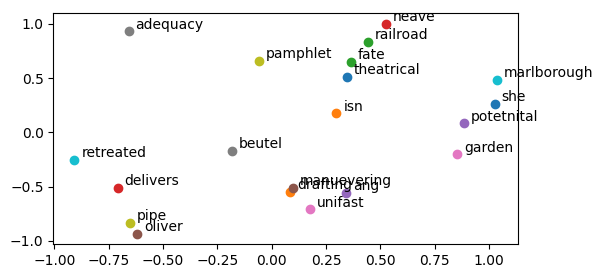

In [44]:
plt.figure(figsize=(6, 3))
for i, word in enumerate(vocab[:20]):  # loop each unique vocab
    x, y = get_embed(word)
    plt.scatter(x, y)
    plt.annotate(word, xy=(x, y), xytext=(5, 2), textcoords="offset points")
plt.show()

## 7. Cosine similarity

Formally the [Cosine Similarity](https://en.wikipedia.org/wiki/Cosine_similarity) $s$ between two vectors $p$ and $q$ is defined as:

$$s = \frac{p \cdot q}{||p|| ||q||}, \textrm{ where } s \in [-1, 1] $$

If $p$ and $q$ is super similar, the result is 1 otherwise 0.


In [45]:
vocab

['theatrical',
 'drafting',
 'railroad',
 'neave',
 'ang',
 'manuevering',
 'garden',
 'beutel',
 'pamphlet',
 'retreated',
 'she',
 'isn',
 'fate',
 'delivers',
 'potetnital',
 'oliver',
 'unifast',
 'adequacy',
 'pipe',
 'marlborough',
 'questar',
 'sam',
 'aura',
 'pathmark',
 'deepening',
 'mckee',
 'pravda',
 'unifying',
 'wisenbaker',
 'frsl',
 've',
 'reconvenes',
 'hnat',
 'vigilance',
 'organized',
 'cbs',
 'qinghai',
 'shareowners',
 'cablevision',
 'castelo',
 'siemens',
 'toys',
 'ky',
 'covert',
 'consummation',
 'dividends',
 'jesse',
 'pragmatic',
 'accounted',
 'northern',
 'occupying',
 'derail',
 'deicits',
 'commerical',
 'btx',
 'rabt',
 'rationalizations',
 'inlet',
 'ldc',
 'sdpv',
 'nuggets',
 'udagawa',
 'rotational',
 'allegheny',
 'amro',
 'bb',
 'rebels',
 'bergung',
 'strauss',
 'pneumo',
 'ciots',
 'scraps',
 'avna',
 'sgs',
 'evaluating',
 'happened',
 'kelvin',
 'yeras',
 'foynes',
 'cravath',
 'diatronics',
 'chemist',
 'predicted',
 'targeting',
 'alone

In [46]:
# let's try similarity between first and second, and second and third
cat = get_embed("cat")
fruit = get_embed("fruit")
animal = get_embed("animal")

In [47]:
# numpy version
from numpy import dot
from numpy.linalg import norm


def cos_sim(a, b):
    cos_sim = dot(a, b) / (norm(a) * norm(b))
    return cos_sim


print(f"cat vs. fruit: ", cos_sim(cat, fruit))
print(f"cat vs. animal: ", cos_sim(cat, animal))
print(f"cat vs. cat: ", cos_sim(cat, cat))

cat vs. fruit:  0.47045106903851563
cat vs. animal:  0.7262116229832918
cat vs. cat:  1.0000000000000002


In [48]:
# scipy version
from scipy import spatial


def cos_sim(a, b):
    cos_sim = 1 - spatial.distance.cosine(
        a, b
    )  # distance = 1 - similarlity, because scipy only gives distance
    return cos_sim


print(f"cat vs. fruit: ", cos_sim(cat, fruit))
print(f"cat vs. animal: ", cos_sim(cat, animal))
print(f"cat vs. cat: ", cos_sim(cat, cat))

cat vs. fruit:  0.4704510690385155
cat vs. animal:  0.7262116229832918
cat vs. cat:  1.0
